## Modules

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import missingno as msno
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

import pickle

from sklearn.metrics import accuracy_score

## Load data

In [3]:
data=pd.read_csv("Data/churn.csv")

In [4]:
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## EDA

In [5]:
df= data.copy()

In [6]:
target= 'Churn'
ls_cont=['tenure', 'MonthlyCharges', 'TotalCharges']
ls_dis= [x for x in df.columns[1:] if x not in ls_cont+ [target]]

### Special case

In [7]:
ls_fail= []
for index, row in df.iterrows():
    total= row["TotalCharges"]
    
    try:
        float(total)
    except :
        ls_fail.append(index)

In [36]:
ls_fail

[488, 753, 936, 1082, 1340, 3331, 3826, 4380, 5218, 6670, 6754]

In [8]:
df.drop(ls_fail, inplace=True)

In [9]:
df['TotalCharges']= df['TotalCharges'].apply(lambda x: float(x))

### Missings

<Axes: >

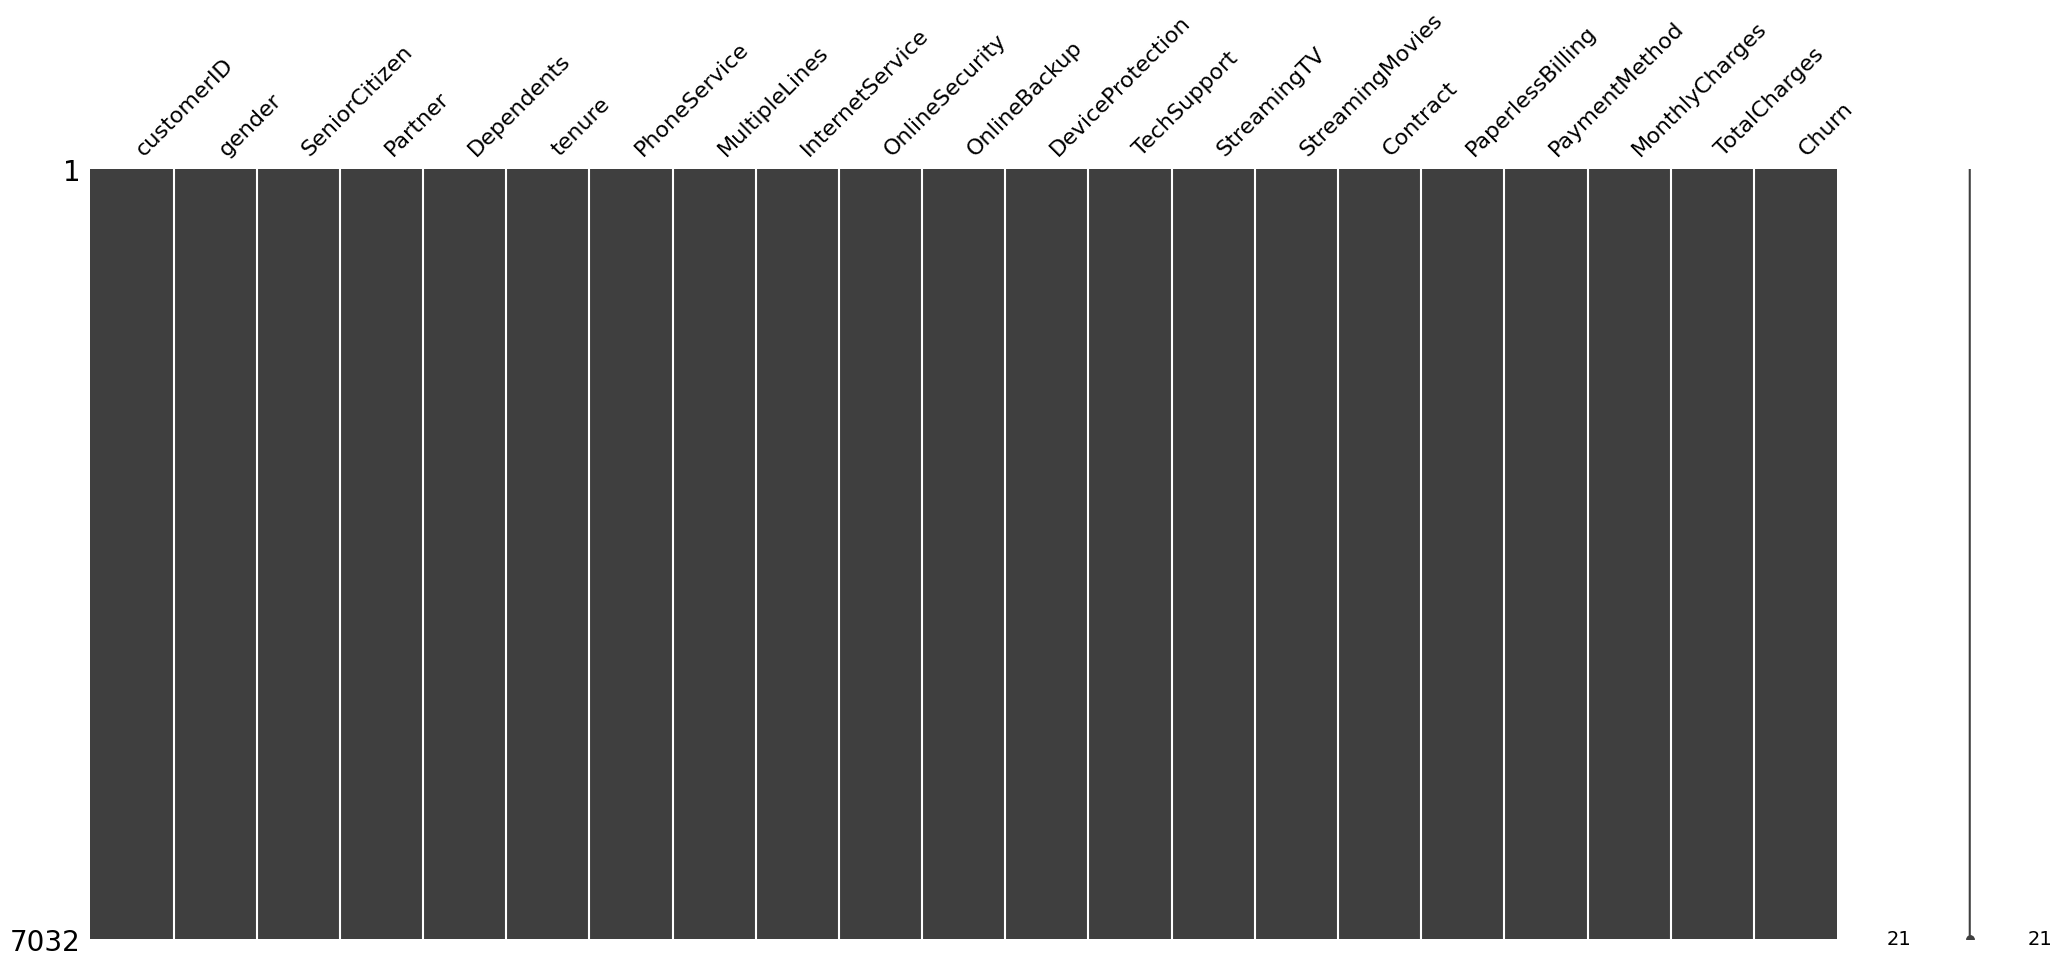

In [34]:
msno.matrix(df)

### Outliers

#### Continuss 

In [ ]:
df.describe()

In [ ]:
for cont in ls_cont:
    sns.histplot(data=df, x= cont)
    plt.show()

#### Disc

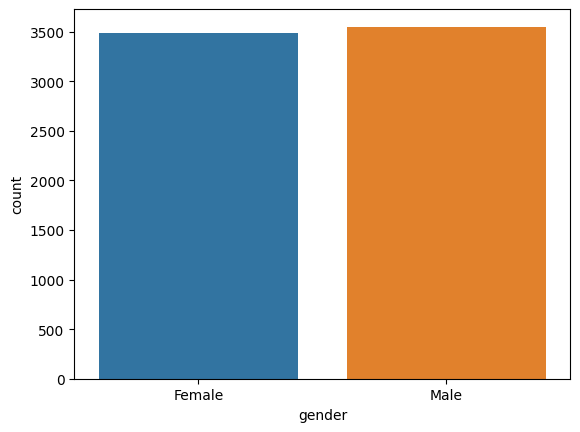

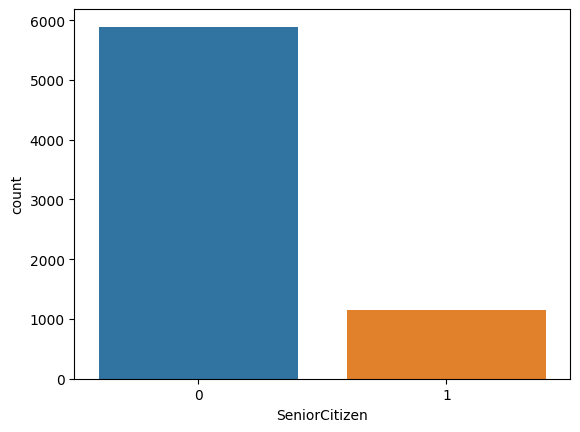

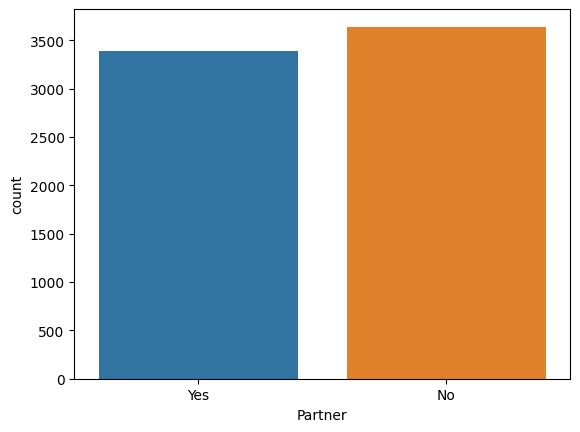

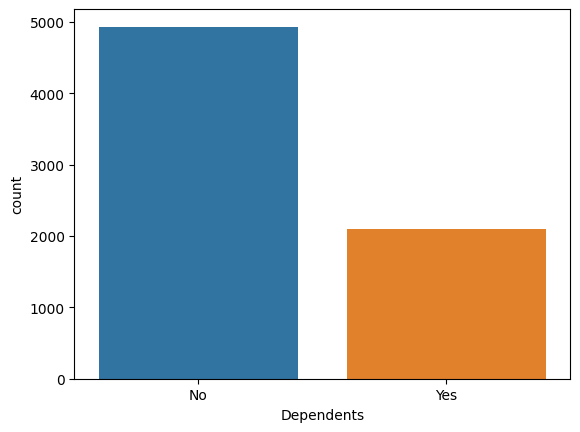

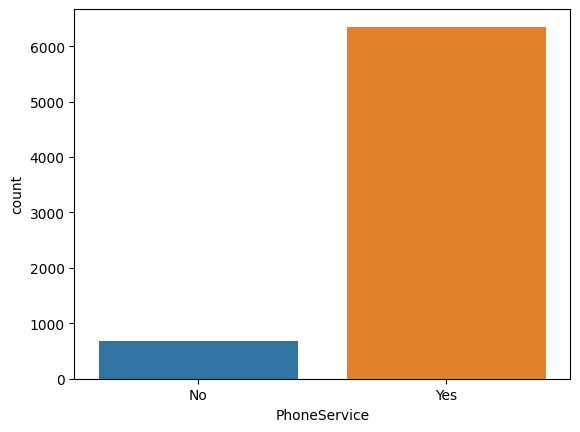

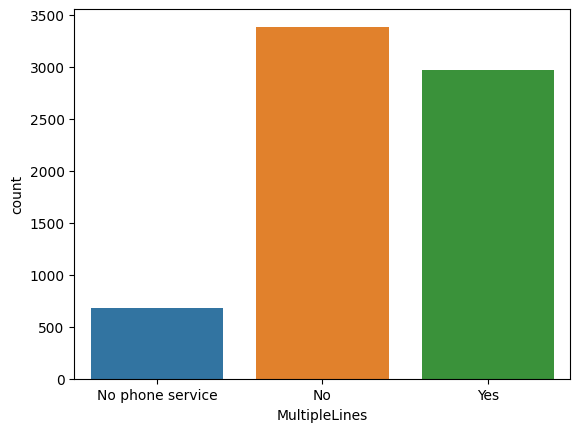

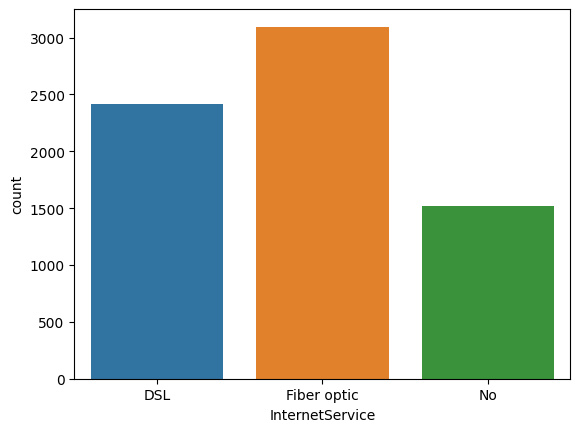

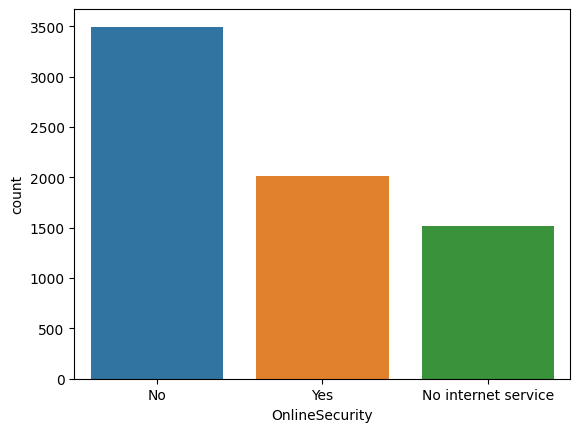

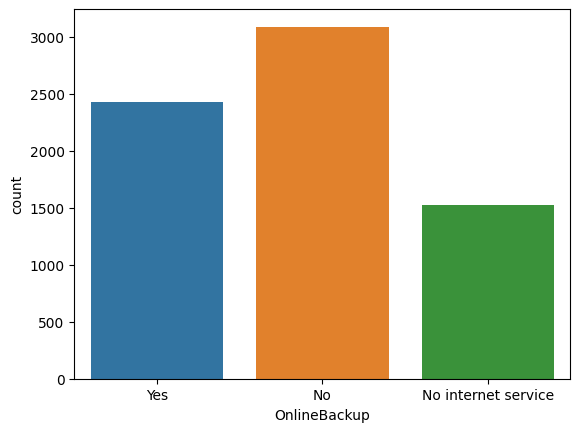

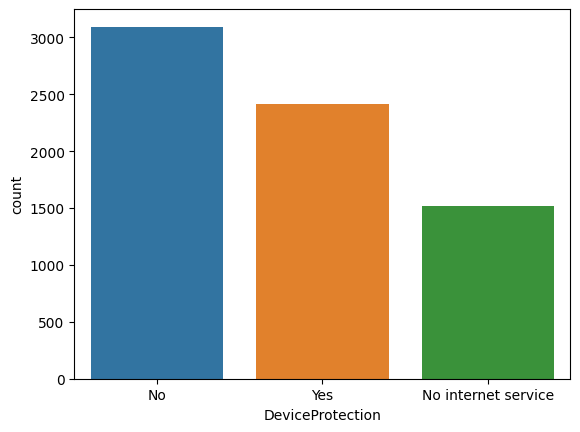

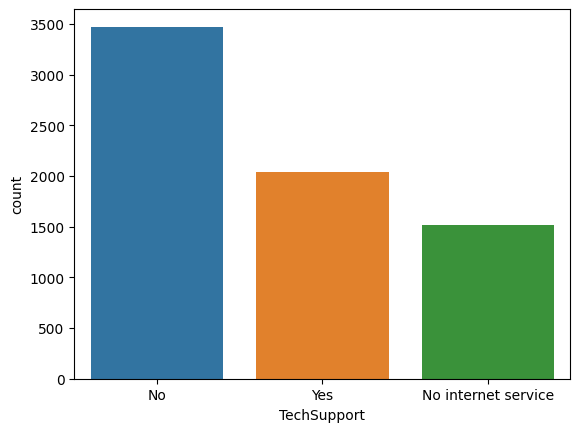

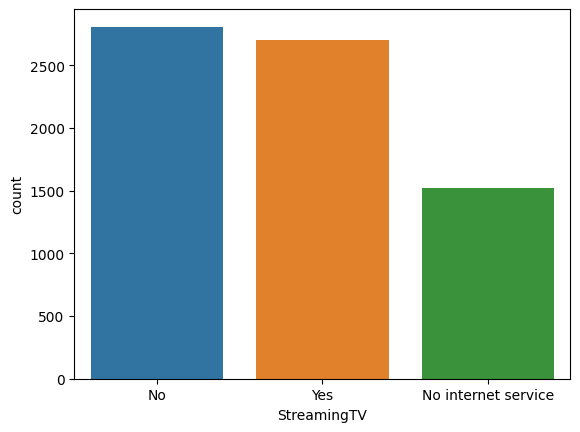

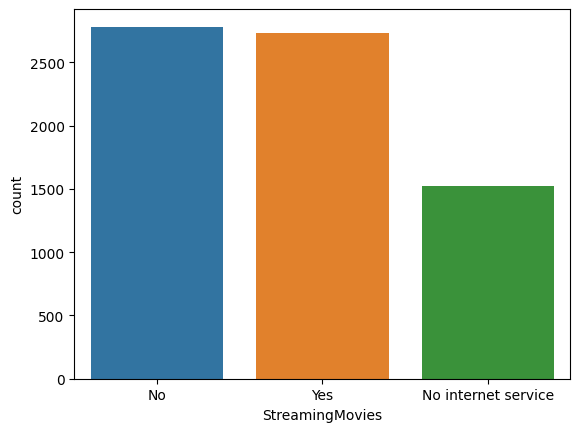

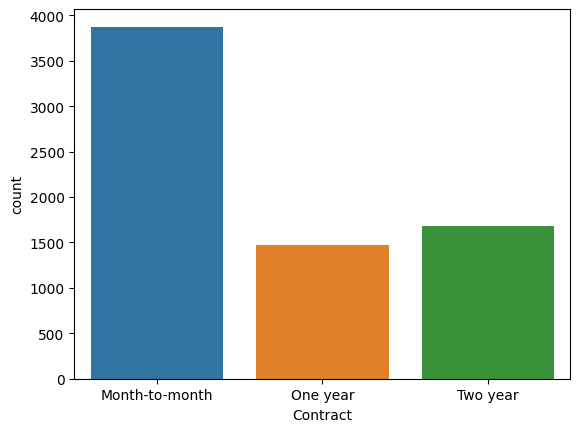

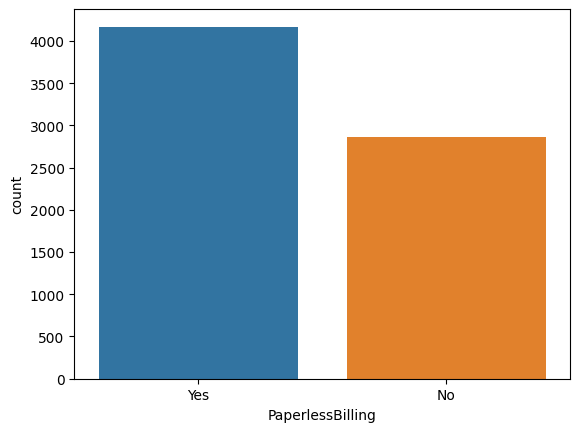

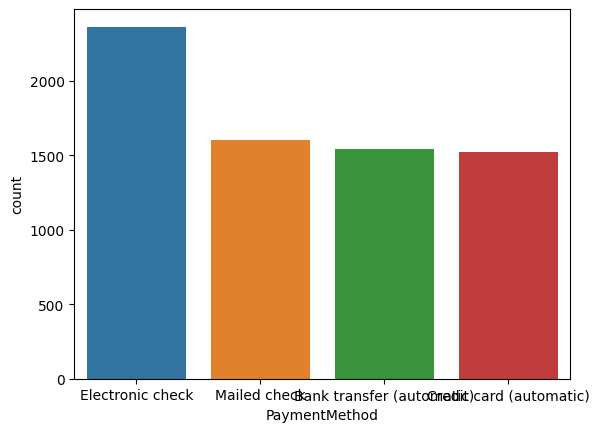

In [62]:
for disc in ls_dis:
    sns.countplot(data= df, x= disc)
    plt.show()

<Axes: xlabel='Churn', ylabel='count'>

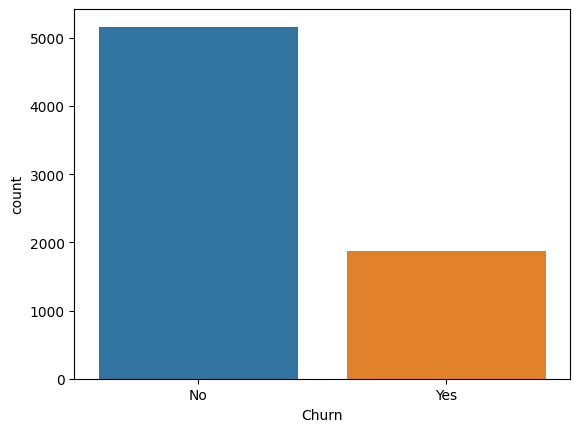

In [127]:
sns.countplot(df, x= 'Churn')

In [271]:
ls_dis.remove("PhoneService")

## Preprossesing

In [10]:
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

### Imputer

In [11]:
for dis in ls_dis:    
    encoder = LabelEncoder()
    df[dis] = encoder.fit_transform(df[dis])
    filename= "ModelsEnc/Label_" +dis+ ".sav"
    pickle.dump(encoder, open(filename, 'wb'))

In [12]:
df[ls_cont]=df[ls_cont].fillna(df[ls_cont].median())

### Train test

In [13]:
X= df[ls_cont+ls_dis]
y= df[target]

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y)

### Scaler

In [15]:
scx= StandardScaler()

In [16]:
X_train= scx.fit_transform(X_train)
X_test= scx.transform(X_test)

In [279]:
filename= "ModelsEnc/Scaler.sav"
pickle.dump(scx, open(filename, 'wb'))

## Models

### Logistic regression

In [17]:
reg = LogisticRegression()

In [18]:
cross_val_score(estimator=reg,X=X_train, y= y_train, cv=5, scoring='roc_auc')

array([0.86031728, 0.83210986, 0.86038206, 0.84223643, 0.8359301 ])

In [19]:
reg.fit(X_train,y_train)

LogisticRegression()

In [20]:
reg.score(X_test,y_test)

0.8052594171997157

In [295]:
champion= reg
filename= "ModelsEnc/champion.sav"
pickle.dump(champion, open(filename, 'wb'))

In [21]:
from sklearn.model_selection import GridSearchCV

In [22]:
grid ={"n_neighbors":np.arange(1,50)}
knn= KNeighborsClassifier()
knn_cv=GridSearchCV(knn,grid,cv=10, scoring='roc_auc') #GridSearchCV
knn_cv.fit(X_train,y_train)

GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])},
             scoring='roc_auc')

In [23]:
knn_cv.best_estimator_

KNeighborsClassifier(n_neighbors=48)

In [24]:
knn_cv.best_score_

0.8232773561705423

In [25]:
y_pred=knn_cv.best_estimator_.predict(X_test)

In [26]:
accuracy_score(y_test,y_pred)

0.7796730632551528

In [27]:
hp = {'max_depth':range(2,10),
'min_samples_leaf':np.arange(0.01,0.1),
'min_samples_split':np.arange(0.01,0.1)}

In [28]:
forest= RandomForestClassifier()

In [29]:
forest_cv=GridSearchCV(forest,hp,cv=5, scoring='roc_auc') #GridSearchCV
forest_cv.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': range(2, 10),
                         'min_samples_leaf': array([0.01]),
                         'min_samples_split': array([0.01])},
             scoring='roc_auc')

In [30]:
y_pred= forest_cv.best_estimator_.predict(X_test)

In [35]:
forest_cv.best_estimator_

RandomForestClassifier(max_depth=8, min_samples_leaf=0.01,
                       min_samples_split=0.01)

In [31]:
forest_cv.best_score_

0.8493363673908995

In [32]:
accuracy_score(y_test,y_pred)

0.8095238095238095

In [296]:
challenger= forest_cv.best_estimator_
filename= "ModelsEnc/challenger.sav"
pickle.dump(champion, open(filename, 'wb'))

In [33]:
np.random.rand()

0.15631013996432586

In [37]:
im_disc= SimpleImputer(strategy="most_frequent")
im_disc.fit(df[ls_dis])

SimpleImputer(strategy='most_frequent')

In [38]:
filename= "ModelsEnc/catSI.sav"
pickle.dump(im_disc, open(filename, 'wb'))

In [40]:
im_cont= SimpleImputer(strategy="median")
im_cont.fit(df[ls_cont])
filename= "ModelsEnc/contSI.sav"
pickle.dump(im_cont, open(filename, 'wb'))